In [1]:
from flexipod_env import FlexipodEnv
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

# import msgpack
# import socket

In [2]:
env = FlexipodEnv(humanoid_task = True)
self = env
env.info = True
_ = env.reset()

humanoid_task:True


In [3]:
observation,reward,done,info = env.step()
print(reward,done,info)

0.0 True {'t': 63011.328125, 'vel_cost': 0.6192748282104731, 'uph_cost': 0.0, 'quad_ctrl_cost': 1.0, 'joint_limit_cost': 1.0}


In [70]:
msg_rec = self.receive()
com_acc = np.mean([m[self.ID_com_acc] for m in msg_rec],axis=0)
com_acc_norm = np.linalg.norm(com_acc)
print(com_acc_norm)
np.clip(1.3-0.1*com_acc_norm,0,1)

2.648559211604314


0.9351440788395685

In [91]:
from numba import njit
from itertools import chain

In [94]:
@njit
def _msg(msg_rec):
    print(msg_rec)

In [95]:
_msg(msg_rec)

C:\Users\boxi\miniconda3\envs\flexipod\lib\site-packages\numba\core\ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'msg_rec' of function '_msg'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-94-c3bc250f6b10>", line 2:
@njit
def _msg(msg_rec):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


TypeError: Failed in nopython mode pipeline (step: nopython mode backend)
cannot reflect element of reflected container: reflected list(reflected list(int64)<iv=None>)<iv=None>


In [93]:
np.fromiter(chain.from_iterable(msg_rec[0]), dtype='float32')

TypeError: 'int' object is not iterable

In [24]:
import gc
%timeit gc.enable()

101 ns ± 0.297 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [29]:
def _processRecMsg(self,msg_rec):
    """processed received message to state action pair"""
    # joint_pos,joint_vel,actuation,orientation,ang_vel,com_acc,com_vel,com_pos.z
    # observation = np.hstack(msg_i[2:-1]+[msg_i[-1][-1]]).astype(np.float32)

    msg_rec_i = msg_rec[0]

    actuation = msg_rec_i[self.ID_actuation] # actuation (size=dof) of the latest observation
    com_z = msg_rec_i[self.ID_com_pos][2]
    # joint position (sin,cos->rad)
    joint_pos = msg_rec_i[self.ID_joint_pos]
    _ = np.arctan2(joint_pos[1::2],joint_pos[::2],self.joint_pos,dtype=np.float32)
    # print(f"self.joint_pos ={self.joint_pos}")

    com_acc = np.mean([m[self.ID_com_acc] for m in msg_rec],axis=0)

    com_acc_norm = np.linalg.norm(com_acc)
    r_acc = np.clip(1.3-0.1*com_acc_norm,0,1) # acceleration reward

    # check if out of range
    joint_pos_limit_check = self.joint_pos - np.clip(self.joint_pos,self.joint_pos_limit[:,0],self.joint_pos_limit[:,1])
    joint_out_of_range_norm = np.linalg.norm(joint_pos_limit_check)
    r_joint_limit = max(0,1.0 - joint_out_of_range_norm*10)
    joint_out_of_range = joint_out_of_range_norm>0.1

    # observation = np.stack([np.hstack(msg_i[2:-1]+[msg_i[self.ID_com_pos][2]])
    observation = np.stack([np.hstack(msg_i[2:-1])
            for msg_i in msg_rec]).astype(np.float32) 

    if self.flatten_obs:
        observation = observation.ravel()
    if self.normalize: # normalize the observation
        observation = observation*self.to_nor_obs_k + self.to_nor_obs_m

    # x velocity
    com_vel_x = sum([msg_i[self.ID_com_vel][0] for msg_i in msg_rec])/len(msg_rec)
    # r_vel = 0.3*np.clip(com_vel_xy,0,1)+0.7 # velocity reward
    r_vel = 0.5*np.clip(com_vel_x,-0.5,1)+0.6 # velocity reward

#         print(orientation_z,com_z)
    # r_orientation = max(0,orientation_z)*min(com_z+0.56,1)
    ori = msg_rec_i[self.ID_orientation]

    if self._humanoid_task:
        orientation_z = ori[2] # z_z, local x vector projected to world z direction
        com_z_min = 0.36
        com_z_offset = 0.56
        orientation_z_min = 0.56
    else: # quadruped task
        orientation_z= ori[0]*ori[4] - ori[1]*ori[3] # z_z, local z vector projected to world z direction
        com_z_min = 0.1
        com_z_offset = 0.8
        orientation_z_min = 0.56

    r_orientation = (np.clip(orientation_z*1.02,0,1)**3)*min(com_z+com_z_offset,1)
    # r_orientation = (np.clip(orientation_z*1.02,0,1)**3)#*min(com_z+com_z_offset,1)

    # x = np.linspace(0,1,400)
    # y = np.clip(np.cos(x*np.pi/2)/np.cos(np.pi/180*15),-1,1)**3
    # plt.plot(x,y)
    # print(com_z+0.56)
    # print(msg_rec_i[self.ID_orientation])

    r_quad_ctrl = max(0,1-0.1 * sum(np.square(actuation))) # quad control cost
    reward =  r_orientation*r_quad_ctrl*r_vel*r_joint_limit

#         reward = orientation_z
    done = True if (orientation_z<orientation_z_min)or(com_z<com_z_min)or(self.episode_steps>=self._max_episode_steps) else False
    # done = True if (orientation_z<orientation_z_min)or(self.episode_steps>=self._max_episode_steps)or joint_out_of_range else False
    # done = True if (self.episode_steps>=self._max_episode_steps) else False
    t = msg_rec_i[self.ID_t]
    if self.info:
        info = {'t':t,
                'r_vel':r_vel,
                'r_orientation':r_orientation,
                'r_quad_ctrl':r_quad_ctrl,
                'r_joint_limit':r_joint_limit,
                'r_acc':r_acc
                }
    else:
        info = {'t':t}
    # if done:
#             print(orientation_z,com_z)
    # _ = [m[self.ID['t']] for m in msg_rec]
    # print(_[0]-_[-1])
    return observation,reward,done,info # TODO, change shape

self.reset()
for k in range(1000):
    msg_rec = self.receive()
    observation,reward,done,info = _processRecMsg(self,msg_rec)
    print(f"{info['r_orientation']:4.2},{info['r_vel']:4.2},{info['r_acc']:4.2}")

 1.0,0.61,0.91
 1.0,0.61,0.92
 1.0,0.61,0.79
 1.0, 0.6,0.88
 1.0, 0.6,0.85
 1.0, 0.6,0.85
 1.0, 0.6,0.82
 1.0, 0.6,0.83
 1.0, 0.6,0.95
 1.0, 0.6,0.83
 1.0, 0.6,0.84
 1.0, 0.6,0.76
 1.0, 0.6,0.96
 1.0, 0.6,0.87
 1.0, 0.6,0.76
 1.0, 0.6,0.76
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6,0.96
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6,0.96
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6,0.97
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6,0.99
 1.0, 0.6,0.87
 1.0, 0.6,0.99
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6,0.95
 1.0, 0.6,0.98
 1.0, 0.6,0.97
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6, 1.0
 1.0, 0.6,

 1.0,0.75, 1.0
 1.0,0.75, 1.0
 1.0,0.75, 1.0
 1.0,0.75, 1.0
 1.0,0.75, 1.0
 1.0,0.76, 1.0
 1.0,0.76, 1.0
 1.0,0.76, 1.0
 1.0,0.76, 1.0
 1.0,0.77, 1.0
 1.0,0.77, 1.0
 1.0,0.77, 1.0
0.99,0.77, 1.0
0.99,0.78, 1.0
0.99,0.78, 1.0
0.99,0.78, 1.0
0.99,0.78, 1.0
0.99,0.78, 1.0
0.99,0.79, 1.0
0.98,0.79, 1.0
0.98,0.79, 1.0
0.98,0.79, 1.0
0.98,0.79, 1.0
0.98,0.79, 1.0
0.98, 0.8, 1.0
0.98, 0.8,0.98
0.98, 0.8, 1.0
0.97, 0.8, 1.0
0.97, 0.8, 1.0
0.97,0.81, 1.0
0.97,0.81, 1.0
0.97,0.81, 1.0
0.97,0.81, 1.0
0.97,0.81, 1.0
0.96,0.81, 1.0
0.96,0.81, 1.0
0.96,0.81, 1.0
0.96,0.82, 1.0
0.96,0.82, 1.0
0.95,0.82, 1.0
0.95,0.82, 1.0
0.95,0.82, 1.0
0.95,0.82, 1.0
0.94,0.82, 1.0
0.94,0.83, 1.0
0.94,0.83, 1.0
0.94,0.83, 1.0
0.93,0.83, 1.0
0.93,0.83, 1.0
0.93,0.84, 1.0
0.93,0.84, 1.0
0.93,0.84, 1.0
0.92,0.84, 1.0
0.92,0.84, 1.0
0.92,0.85, 1.0
0.91,0.85,0.99
0.91,0.85,0.98
0.91,0.85,0.97
0.91,0.86,0.96
 0.9,0.86,0.95
 0.9,0.86,0.99
 0.9,0.87, 1.0
0.89,0.87, 1.0
0.89,0.87, 1.0
0.89,0.88, 1.0
0.88,0.88, 1.0
0.88,0.88,

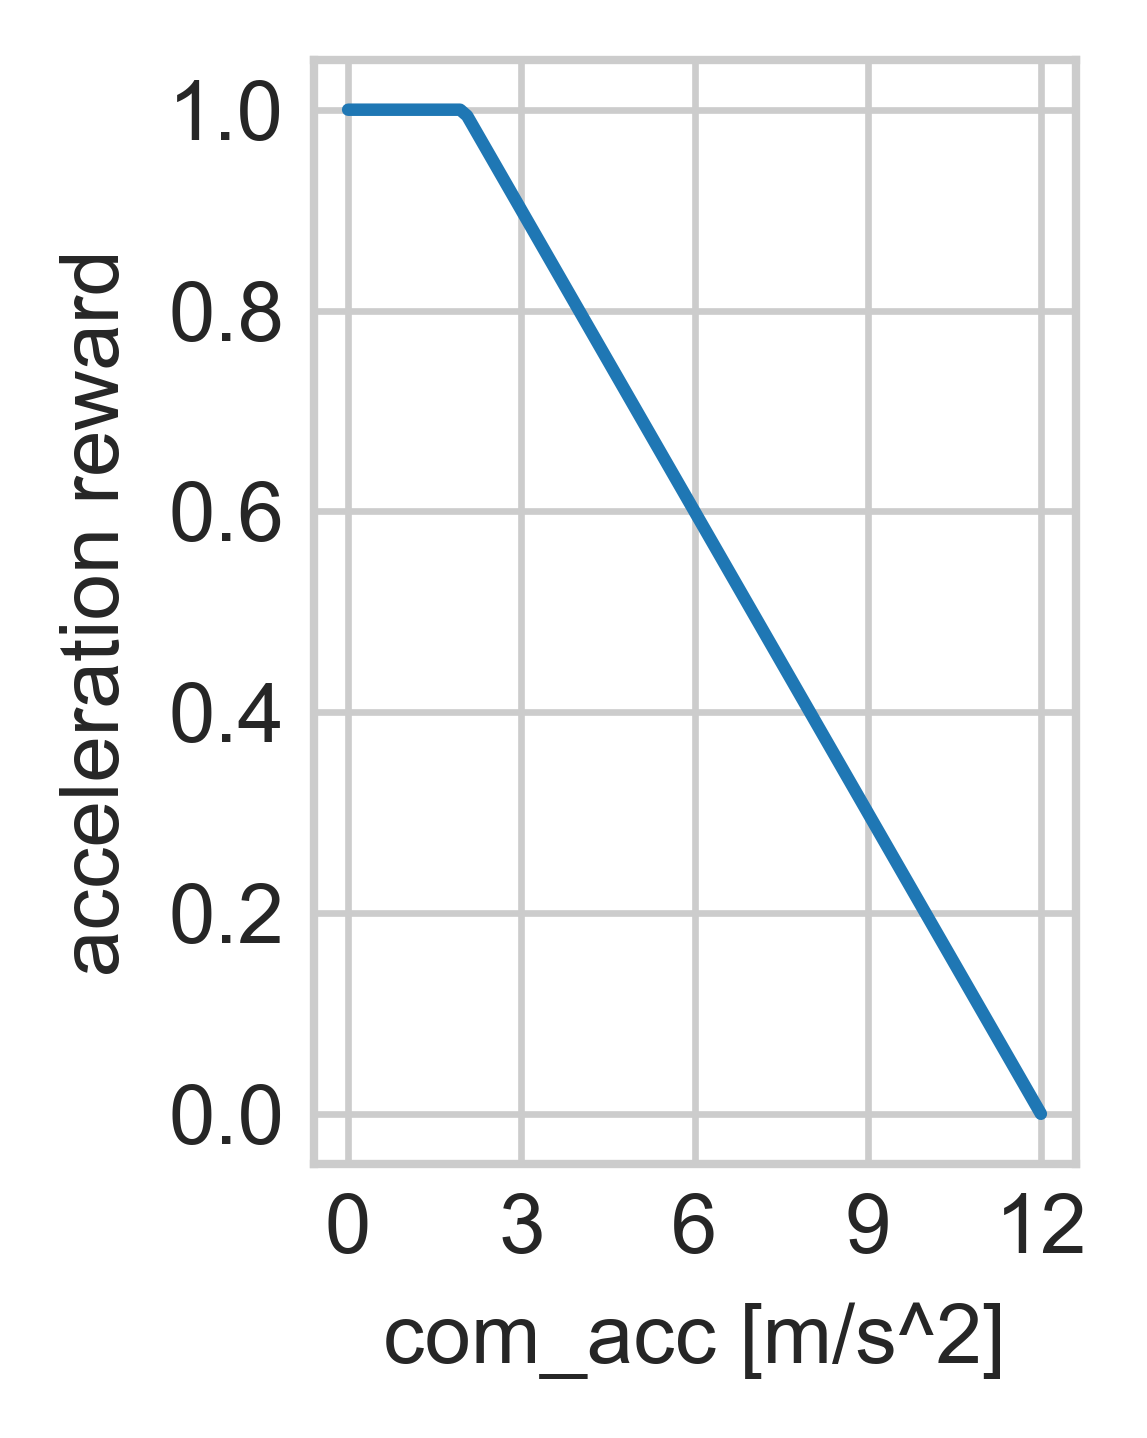

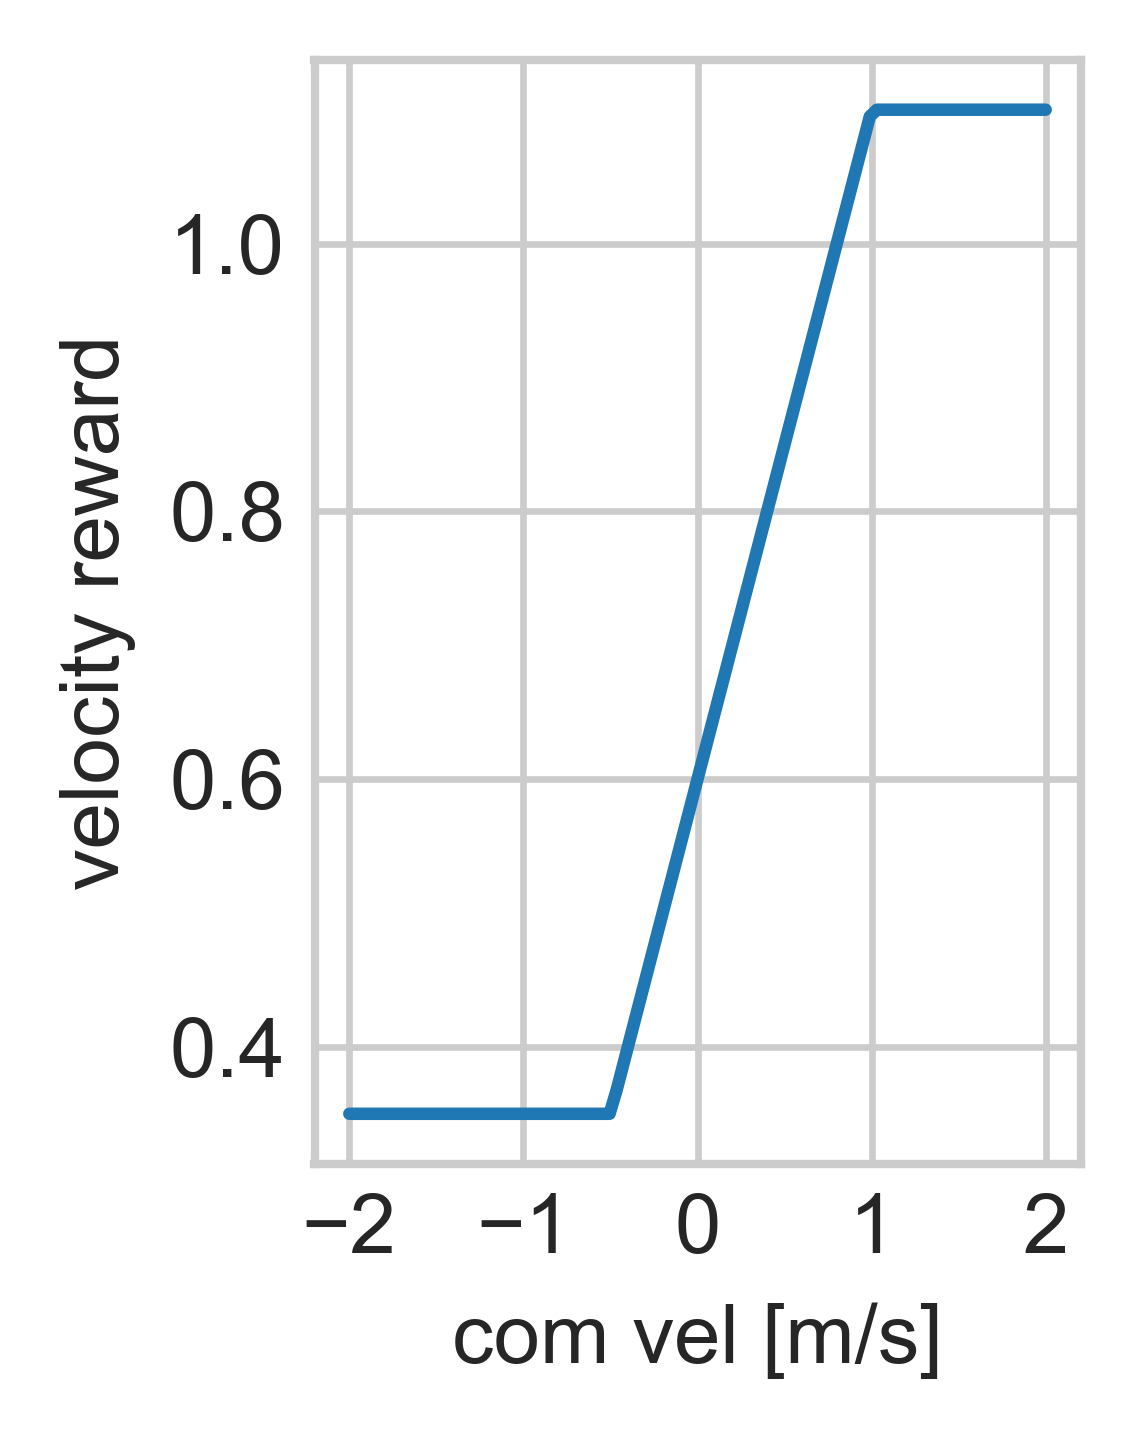

In [15]:
dpi = 300

x_min,x_max = (0,12)
x = np.linspace(x_min,x_max,100)
y = np.clip(1.2-0.1*x,0,1)
plt.figure(figsize=(2,2.5),dpi=dpi)
plt.plot(x,y)
plt.xticks(np.linspace(x_min,x_max,5))
plt.xlabel("com_acc [m/s^2]")
plt.ylabel("acceleration reward")
plt.tight_layout()
plt.show()

x_min,x_max = (-2,2)
x = np.linspace(x_min,x_max,100)
y = 0.5*np.clip(x,-0.5,1)+0.6
plt.figure(dpi=dpi,figsize=(2,2.5))
plt.plot(x,y)
plt.xticks(np.linspace(x_min,x_max,5))
plt.xlabel("com vel [m/s]")
plt.ylabel("velocity reward")
plt.tight_layout()

In [34]:
#
#   Hello World client in Python
#   Connects REQ socket to tcp://localhost:5555
#   Sends "Hello" to server, expects "World" back
#

import zmq
print(f"Current libzmq version is {zmq.zmq_version()}")
print(f"Current  pyzmq version is {zmq.__version__}")

context = zmq.Context()

#  Socket to talk to server
print("Connecting to hello world server…")
socket = context.socket(zmq.REQ)
socket.connect("tcp://localhost:5555")

#  Do 10 requests, waiting each time for a response
for request in range(10):
    print("Sending request %s …" % request)
    socket.send(b"Hello")

    #  Get the reply.
    message = socket.recv()
    print("Received reply %s [ %s ]" % (request, message))

Current libzmq version is 4.3.4
Current  pyzmq version is 22.0.3
Connecting to hello world server…
Sending request 0 …
Received reply 0 [ b'World' ]
Sending request 1 …
Received reply 1 [ b'World' ]
Sending request 2 …
Received reply 2 [ b'World' ]
Sending request 3 …
Received reply 3 [ b'World' ]
Sending request 4 …
Received reply 4 [ b'World' ]
Sending request 5 …
Received reply 5 [ b'World' ]
Sending request 6 …
Received reply 6 [ b'World' ]
Sending request 7 …
Received reply 7 [ b'World' ]
Sending request 8 …
Received reply 8 [ b'World' ]
Sending request 9 …
Received reply 9 [ b'World' ]
